***Images classifier - using keras. Building convolution neural network (CNN) To classify 12 plants categories***





In [3]:
import numpy as np
import pandas as pd
import os
from os import listdir, makedirs, getcwd, remove

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
%matplotlib inline
import cv2 as cv
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import mean_absolute_error
pd.options.display.precision = 4

from numpy.random import seed
seed(0)
from tensorflow import set_random_seed
set_random_seed(0)

import seaborn as sns
import imageio
from imageio import imread
import skimage
from skimage import io, transform

from PIL import Image, ImageEnhance, ImageFilter
import glob

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold, KFold, RepeatedKFold, GroupKFold, GridSearchCV, train_test_split, TimeSeriesSplit
from sklearn import metrics
from sklearn import linear_model
import seaborn as sns
import warnings; 
warnings.filterwarnings("ignore")
warnings.simplefilter('ignore') 

import keras
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.models import Sequential
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers.core import Activation
from keras.layers.core import Flatten
from keras.layers.core import Dropout
from keras.layers.core import Dense
from keras.layers.normalization import BatchNormalization
from keras.callbacks import ModelCheckpoint, Callback, EarlyStopping, ReduceLROnPlateau


Using TensorFlow backend.


In [4]:
!ls

sample_data


Load images data from Kaggle

In [5]:
os.environ['KAGGLE_USERNAME']='ruthberenstein' #xxxxxx
os.environ['KAGGLE_KEY']='31d8b00ec5cc364d42134cbd6da6aa04' #xxxxxx

!kaggle datasets download -d vbookshelf/v2-plant-seedlings-dataset # api copied from kaggle

100% 3.18G/3.19G [00:49<00:00, 153MB/s]
100% 3.19G/3.19G [00:49<00:00, 68.6MB/s]


In [0]:
!unzip -qq v2-plant-seedlings-dataset.zip "nonsegmentedv2/*" 

In [7]:
!ls

nonsegmentedv2	sample_data  v2-plant-seedlings-dataset.zip


**All images are grouped in 12 folders labled by plant specie.**

In [8]:
main_dir = 'nonsegmentedv2'
folders=os.listdir('nonsegmentedv2/')
print(folders)

['Common wheat', 'Sugar beet', 'ShepherdтАЩs Purse', 'Small-flowered Cranesbill', 'Black-grass', 'Scentless Mayweed', 'Charlock', 'Cleavers', 'Loose Silky-bent', 'Common Chickweed', 'Fat Hen', 'Maize']


The number of images in each plant category, and the sizes of the images

In [9]:
total_images = 0
im_width =[]
im_height=[]
largeim=''
smallim=''

for folder in folders:
    images_list = os.listdir(main_dir+'/'+folder)
    num_images = len(images_list)    
    total_images = total_images + num_images
    print(str(folder) + ':' + ' ' + str(num_images))
    
    for imgfile in glob.glob(main_dir+'/'+folder+"/*.png"):
      im = Image.open(imgfile)
      im_width.append(im.size[1])
      im_height.append(im.size[0])
      if im.size[1]==578:
        largeim=imgfile
      if im.size[1]==56:
        smallim=imgfile
    
print('\n')
print('Total Images: ', total_images)
print('\n')
print('maximum images width:',max(im_width),'minimum images width:',min(im_width))
print('maximum images height:',max(im_height),'minimum images height:',min(im_height))

Common wheat: 253
Sugar beet: 463
ShepherdтАЩs Purse: 274
Small-flowered Cranesbill: 576
Black-grass: 309
Scentless Mayweed: 607
Charlock: 452
Cleavers: 335
Loose Silky-bent: 762
Common Chickweed: 713
Fat Hen: 538
Maize: 257


Total Images:  5539


maximum images width: 3457 minimum images width: 49
maximum images height: 3652 minimum images height: 49


**Lets watch some images from each plant**

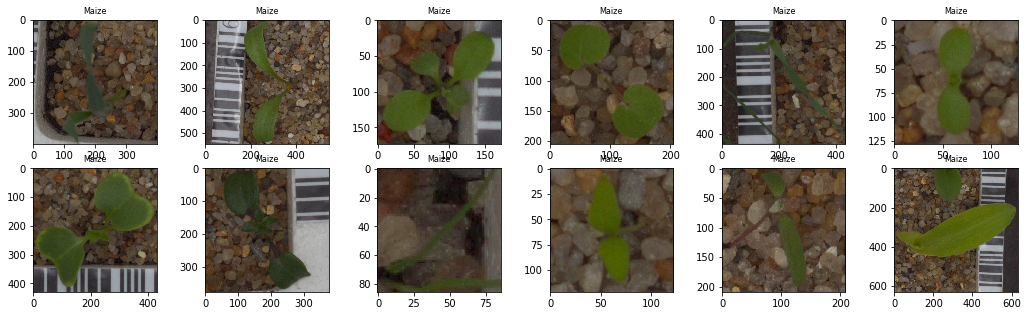

In [10]:
fig, ax = plt.subplots(2, 6, figsize=(18, 5)) 
f=0
for i in range(2):
  for j in range(6):
      file=main_dir+'/'+ folders[f] +'/50.png'
      im=plt.imread(file)
      ax[i,j].imshow(im,resample=True)
      ax[i,j].set_title(folder, fontsize=8)
      f+=1

**Distribiution curve of images width**

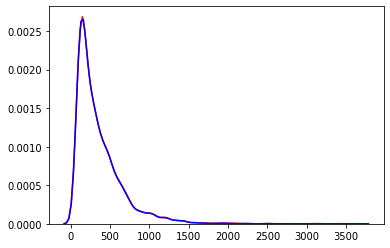

In [11]:

sizes=im_width + im_height
merged_list = [(im_width[i], im_height[i]) for i in range(0, len(im_width))] 

ax = sns.kdeplot(im_width, color="r")
ax = sns.kdeplot(im_height, color="b")

In [12]:
def most_common(lst):
    return max(set(lst), key=lst.count)
print('Most common images width:', most_common(im_width),'and height:',most_common(im_height))

Most common images width: 115 and height: 115


**Since the images width peak is of 115, i choose to resize all images to 128x128 when building the CNN model**

**Resizing and building CNN model**

In [0]:
batch_Size=64

In [23]:
train_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        validation_split=0.3)

train_generator = train_datagen.flow_from_directory(
        main_dir,
        target_size=(128,128),
        batch_size=batch_Size,
        class_mode='categorical',
        subset='training')

validation_generator = train_datagen.flow_from_directory(
        main_dir,
        target_size=(128,128),
        batch_size=batch_Size,
        class_mode='categorical',
        subset='validation')



Found 3884 images belonging to 12 classes.
Found 1655 images belonging to 12 classes.


In [0]:
input_shape=(128,128,3)
classes=12

In [0]:
# saving best epoch

earlystopper = EarlyStopping(monitor='loss', patience=8, verbose=1)

checkpoint1 = ModelCheckpoint('best_model_val_acc_1.h5', monitor='val_acc', verbose=1, 
                              save_best_only=True, save_weights_only=True)

In [0]:
model = Sequential()
model.add(Conv2D(64,(3, 3), activation='relu', input_shape=input_shape, padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(BatchNormalization()) 
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.15))
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(BatchNormalization()) 
model.add(Dropout(0.15))       
model.add(Dense(classes, activation='softmax'))

In [0]:
#steps=len(train_generator.filenames) // batch_Size

In [36]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])  # optimizer=RMSprop()

history = model.fit_generator(train_generator,                  
                    epochs=25, 
                    #steps_per_epoch=steps,
                    verbose=1,
                    callbacks=[earlystopper, checkpoint1,ReduceLROnPlateau(patience=2)],
                    validation_data = validation_generator)


Epoch 1/25
61/61 [==============================] - 50s 818ms/step - loss: 1.7270 - acc: 0.5033 - val_loss: 2.8522 - val_acc: 0.3927

Epoch 00001: val_acc improved from -inf to 0.39275, saving model to best_model_val_acc_1.h5
Epoch 2/25
61/61 [==============================] - 41s 676ms/step - loss: 0.8743 - acc: 0.7028 - val_loss: 2.6816 - val_acc: 0.3897

Epoch 00002: val_acc did not improve from 0.39275
Epoch 3/25
61/61 [==============================] - 43s 700ms/step - loss: 0.6405 - acc: 0.7908 - val_loss: 2.1967 - val_acc: 0.4767

Epoch 00003: val_acc improved from 0.39275 to 0.47674, saving model to best_model_val_acc_1.h5
Epoch 4/25
61/61 [==============================] - 43s 702ms/step - loss: 0.4971 - acc: 0.8377 - val_loss: 1.5377 - val_acc: 0.6175

Epoch 00004: val_acc improved from 0.47674 to 0.61752, saving model to best_model_val_acc_1.h5
Epoch 5/25
61/61 [==============================] - 43s 698ms/step - loss: 0.4019 - acc: 0.8666 - val_loss: 1.0702 - val_acc: 0.6556

In [0]:
def drow_history(history, metric):
    plt.plot(history.history[metric])
    plt.plot(history.history['val_'+ metric])
    plt.title('model '+metric)
    plt.ylabel(metric)
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()  

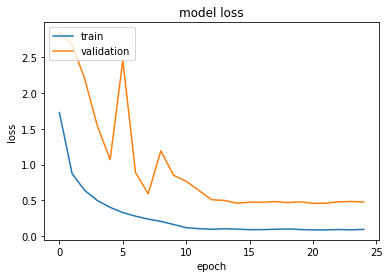

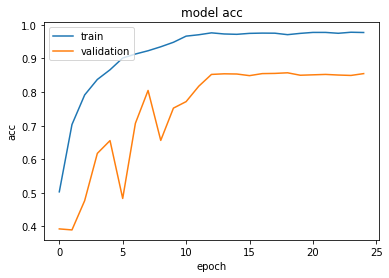

In [38]:
drow_history(history, 'loss')
drow_history(history, 'acc')

In [39]:
  print('Best val Acc: {:4f}'.format(max(history.history['val_acc'])))       


Best val Acc: 0.857402
